## Multirate Signal Processing - Seminar 2

Improved filterbank using filter design techiques. 

Import the necessary libraries first.

In [1]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]

Set Parameters

In [2]:
nTabs = 64
nSubbands = 4

Load audio file from folder data.

In [3]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


### Design filters using windowing

Definition of helper functions:
* sinc
* impulse response of ideal lowpass (sincInpulse)
* Cosine modulator 

In [4]:
def sinc(x):
    return (np.sin(x)/x)

def sincImpulse(N,wc):
    n = np.arange(0,N)
    delay = (N-1)/2.0
    h = (wc/np.pi)*sinc((n-delay)*wc)
    return h

def cosModulator(N,w0):
    n = np.arange(0,N)
    m = np.cos(w0*n)
    return m

Definitions of window functions:
* raised cosine window
* sin window

In [5]:
def raisedCosWinow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        c = 0.5-0.5*np.cos(2*np.pi/N*(n+0.5))
    else: # odd
        c = 0.5-0.5*np.cos(2*np.pi/(N+1)*(n+1))    
    return c

def sinWindow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        s = np.sin(np.pi/N*(n+0.5))
    else:
        s = np.sin(np.pi/(N+1)*(n+1))
    return s

Use optimization to create window:

In [6]:
def errfunc(h):
    numfreqsamples=1024
    #desired passband:
    pb=int(numfreqsamples*0.05)
    tb=int(numfreqsamples*0.01)
    w, H = sig.freqz(h,1,numfreqsamples)
    H_desired=np.concatenate((np.ones(pb), np.zeros(numfreqsamples-pb)))
    weights = np.concatenate((np.ones(pb), np.zeros(tb), 100*np.ones(numfreqsamples-pb-tb)+1000*np.arange(numfreqsamples-pb-tb)))
    err = np.sum(np.abs(H-H_desired)*weights)
    return err

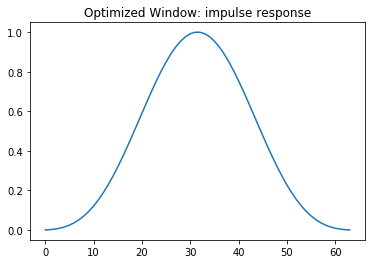

In [7]:
# start off with a raised cosine window instead of random numbers to have a unvarying end result
opt_start = raisedCosWinow(nTabs)
#omega, H =sig.freqz(-1.0*opt_start)
#plt.plot(omega, 20*np.log10(abs(H)+1e-6))
#plt.show()
minout = opt.minimize(errfunc, opt_start, tol=1e-6)
h = minout.x
h_opt = abs(h) / np.amax(abs(h))
plt.plot(h_opt)
plt.title('Optimized Window: impulse response')
plt.show()

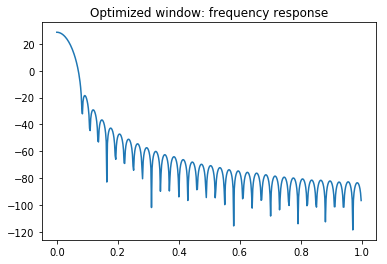

In [8]:
omega, H =sig.freqz(h_opt)
plt.plot(omega/np.pi, 20*np.log10(abs(H)+1e-6))
plt.title('Optimized window: frequency response')
plt.show()

Compare resulting lowpass filter with the previous homework:

In [9]:
wLp_sinc = np.pi * 0.25
prototype_LpOpt = sincImpulse(nTabs, wLp_sinc) * h_opt
prototype_old = sincImpulse(nTabs, wLp_sinc) * raisedCosWinow(nTabs)

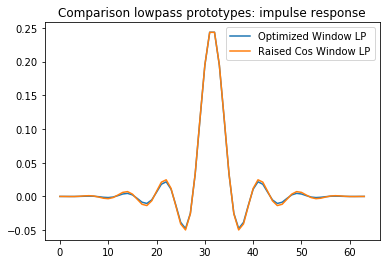

In [10]:
plt.plot(prototype_LpOpt)
plt.plot(prototype_old)
plt.title('Comparison lowpass prototypes: impulse response')
plt.legend(['Optimized Window LP', 'Raised Cos Window LP'])
plt.show()

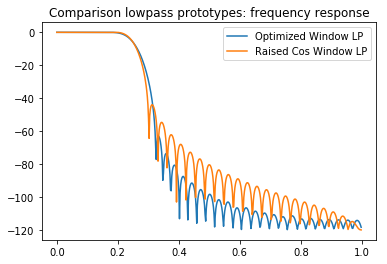

In [11]:
omega, H =sig.freqz(prototype_LpOpt)
plt.plot(omega/np.pi, 20*np.log10(abs(H)+1e-6))
omega, H =sig.freqz(prototype_old)
plt.plot(omega/np.pi, 20*np.log10(abs(H)+1e-6))
plt.title('Comparison lowpass prototypes: frequency response')
plt.legend(['Optimized Window LP', 'Raised Cos Window LP'])
plt.show()

Build together filterbank: use previously plotted LP for HP and create another LP with 1/2 bandwidth for bandpass filters:

In [33]:
fb = []

#LP
lp = 0.1 * prototype_LpOpt / max(abs(prototype_LpOpt))
fb.append(lp)

#BP1
prototype_BpOpt = sincImpulse(nTabs, np.pi * 0.1) * h_opt
mod_bp1 = cosModulator(nTabs, (2*1+1) * np.pi/(2*4))
bp1 = prototype_BpOpt * mod_bp1
bp1 = 0.1 * bp1 / max(abs(bp1))
fb.append(bp1)

#BP2
mod_bp2 = cosModulator(nTabs, (2*2+1) * np.pi/(2*4))
bp2 = prototype_BpOpt * mod_bp2
bp2 = 0.1 * bp2 / max(abs(bp2))
fb.append(bp2)


#HP
mod_hp = cosModulator(nTabs, np.pi)
hp = prototype_LpOpt * mod_hp
hp = 0.1 * hp / max(abs(hp))
fb.append(hp)


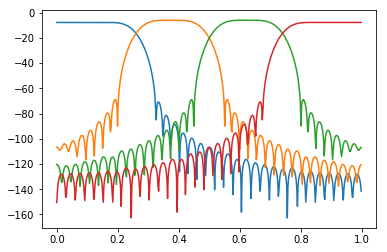

In [34]:
for h in fb:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H)))
plt.show()

Use filterbank on audio signal and downsample

In [35]:
decomposed = [np.convolve(h,audio,mode='full') for h in fb]
downsampledBands = [s[::nSubbands] for s in decomposed]

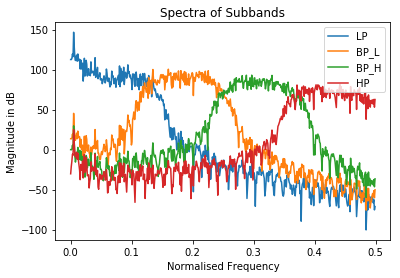

In [36]:
for s in decomposed:
    w,H = sig.freqz(s)
    # plot magnitude
    plt.plot(w/(np.pi*2),20*np.log10(np.abs(H)))

plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Spectra of Subbands')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

In [37]:
i = 1
fs_ds = int(fs/nSubbands)
for band in downsampledBands:
    print("Playing {}th subband.".format(i))
    band_norm = 32768 * band / max(abs(band))
    sound.sound(band_norm,fs_ds)
    i += 1

Playing 1th subband.
* done
Playing 2th subband.
* done
Playing 3th subband.
* done
Playing 4th subband.
* done


Plot excert of signal and subband k=0

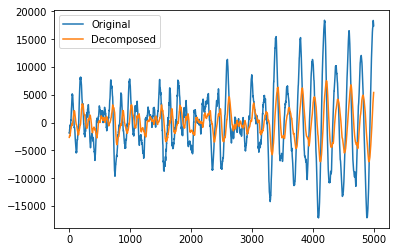

In [38]:
plt.plot(audio[55000:60000])
plt.plot(decomposed[0][55000:60000])
plt.legend(['Original', 'Decomposed'])
plt.show()

Reconstruction:
* upsampling and filtering
* add subbands together

In [39]:
zeroBands = [np.zeros_like(band) for band in decomposed]
usBands = []
for zBand, dsBand in zip(zeroBands, downsampledBands):
    zBand[::4] = dsBand
    usBands.append(zBand)

filterdUs = [np.convolve(h,band,mode='full') for h,band in zip(fb, usBands)]

In [40]:
recon = np.zeros_like(filterdUs[0])
for band in filterdUs:
    recon += band
recon = 32768 * recon / max(abs(recon))
sound.sound(recon,fs)

* done


In [41]:
sound.sound(audio, fs)

* done


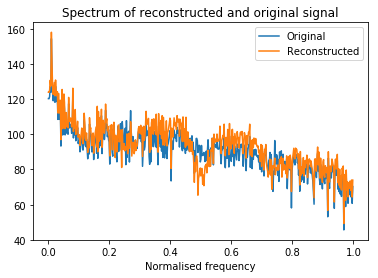

In [42]:
wOriginal, hOriginal = sig.freqz(audio)
plt.plot(wOriginal/(np.pi),20*np.log10(np.abs(hOriginal)))

w,H = sig.freqz(recon)
plt.plot(w/(np.pi),20*np.log10(np.abs(H)))

plt.title('Spectrum of reconstructed and original signal')
plt.xlabel('Normalised frequency')
plt.legend(['Original', 'Reconstructed'])
plt.show()

In [22]:
print(FB[0].shape)

NameError: name 'FB' is not defined

In [ ]:
signal = np.array([[1.0, 3.0, 3.0, 2.0, 5.0]]).T

In [ ]:
print(signal)

In [ ]:
print(signal.shape)

In [ ]:
def convMatrix(h,N):
    hLen = h.shape[0]
    Mat = np.zeros((hLen+N-1,N))
    for shift in range(0,N):
        Mat[shift:shift+hLen,shift] = h
    return Mat

In [ ]:
cMat = convMatrix(FB[0],5)
print(cMat)

In [ ]:
out = np.dot(cMat,signal)

In [ ]:
print(out)